In [1]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Global configuration 

In [3]:
TEST_SIZE = 0.2
RANDOM_SEED = 42
MODEL_FILENAME = 'type_multimodal.pkl'

COL_TITLE = 'Title'
COL_AUTHOR = 'Author'
COL_LOCATION = 'Location'
COL_DATE = 'Date'
COL_TYPE_TARGET = 'Type'

Features processing

In [5]:
title_transformer = TfidfVectorizer( # applies a transformer 
    ngram_range=(1, 2),
    max_df=0.7, # ignores words appearing in more than 70% of the corpus
    stop_words='english'
)

categorical_transformer = OneHotEncoder( # one-hot encoding for categorical metadata
    handle_unknown='ignore',
    sparse_output=False
)

numerical_transformer = StandardScaler() # standardizes numerical data

preprocessor = ColumnTransformer( # applies transformation on resepective columns
    transformers=[
        ('text', title_transformer, COL_TITLE),
        ('cat', categorical_transformer, [COL_AUTHOR, COL_LOCATION]),
        ('date', numerical_transformer, [COL_DATE])
    ],
    remainder='drop'
)

Load and prepare data

In [7]:
df = pd.read_csv('./data/training_data.csv')
df.dropna(
    subset=[COL_TYPE_TARGET, COL_TITLE, COL_AUTHOR, COL_LOCATION, COL_DATE],
    inplace=True
) # drop rows with missing values
X = df.drop(COL_TYPE_TARGET, axis=1) # features
y = df[COL_TYPE_TARGET] # target label
print(f"Total usable samples: {len(y)}")

Total usable samples: 15091


Split into training and testing sets 

In [9]:
X_train, X_test, y_train, y_test = train_test_split( # shuffles and splits the data
    X,
    y,
    test_size=TEST_SIZE,
    random_state=RANDOM_SEED,
    stratify=y # keeps same proportion of genre in training and testing sets
)
print(f"Training samples: {len(y_train)}")
print(f"Testing samples : {len(y_test)}")

Training samples: 12072
Testing samples : 3019


Model pipeline

In [11]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LinearSVC(
        C=1.0,
        class_weight='balanced', # adjusts for genres that are not well represented
        random_state=RANDOM_SEED
    ))
])

Training phase

In [13]:
pipeline.fit(X_train, y_train)
print("Cross-validation (5-fold) on training set:")
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5) # divides the model in 5 folds and tests 5 times
print(f"Scores: {cv_scores}")
print(f"Mean CV accuracy: {cv_scores.mean():.4f}")

/opt/anaconda3/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Cross-validation (5-fold) on training set:


/opt/anaconda3/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Scores: [0.88240166 0.86004141 0.87903894 0.87696769 0.88193869]
Mean CV accuracy: 0.8761


Testing phase

In [15]:
test_accuracy = pipeline.score(X_test, y_test)
print(f"Final test accuracy: {test_accuracy:.4f}")
y_pred = pipeline.predict(X_test) # predicts type for the test set

Final test accuracy: 0.8804


Classification report

In [17]:
print("Classification report:")
print(classification_report(y_test, y_pred, zero_division=0))

Classification report:
              precision    recall  f1-score   support

      ballad       0.94      0.80      0.86        20
      comedy       0.90      0.93      0.92        88
       elegy       0.94      0.83      0.88        18
        hymn       1.00      0.67      0.80         6
       lines       0.87      0.81      0.84        16
       lyric       1.00      0.73      0.85        15
      melody       0.67      0.40      0.50         5
       novel       0.82      0.92      0.87       557
         ode       0.93      0.83      0.88       115
       opera       0.97      0.73      0.83        51
   pantomime       0.80      1.00      0.89         4
       parod       0.00      0.00      0.00         2
    pastoral       0.80      0.57      0.67         7
        play       0.88      0.82      0.85       103
        poet       0.92      0.92      0.92       511
  recitation       0.67      0.67      0.67         6
       rhyme       0.93      0.81      0.87        16
    

Normalized confusion matrix

In [19]:
labels = pipeline.classes_
cm_norm = confusion_matrix(
    y_test,
    y_pred,
    labels=labels,
    normalize='true'
)
cm_df = pd.DataFrame(cm_norm, index=labels, columns=labels)
print("Normalized confusion matrix (rows = true labels):")
print(cm_df.round(2))

Normalized confusion matrix (rows = true labels):
            ballad  comedy  elegy  hymn  lines  lyric  melody  novel   ode  \
ballad        0.80    0.00   0.00  0.00   0.00   0.00    0.00   0.05  0.00   
comedy        0.00    0.93   0.00  0.00   0.00   0.00    0.00   0.01  0.00   
elegy         0.00    0.00   0.83  0.00   0.00   0.00    0.00   0.00  0.00   
hymn          0.00    0.00   0.00  0.67   0.00   0.00    0.00   0.00  0.00   
lines         0.00    0.00   0.00  0.00   0.81   0.00    0.00   0.00  0.00   
lyric         0.07    0.00   0.00  0.00   0.00   0.73    0.00   0.00  0.07   
melody        0.00    0.00   0.00  0.00   0.00   0.00    0.40   0.00  0.00   
novel         0.00    0.00   0.00  0.00   0.00   0.00    0.00   0.92  0.00   
ode           0.00    0.00   0.00  0.00   0.00   0.00    0.00   0.03  0.83   
opera         0.00    0.00   0.00  0.00   0.00   0.00    0.00   0.04  0.00   
pantomime     0.00    0.00   0.00  0.00   0.00   0.00    0.00   0.00  0.00   
parod         

Plot the confusion matrix

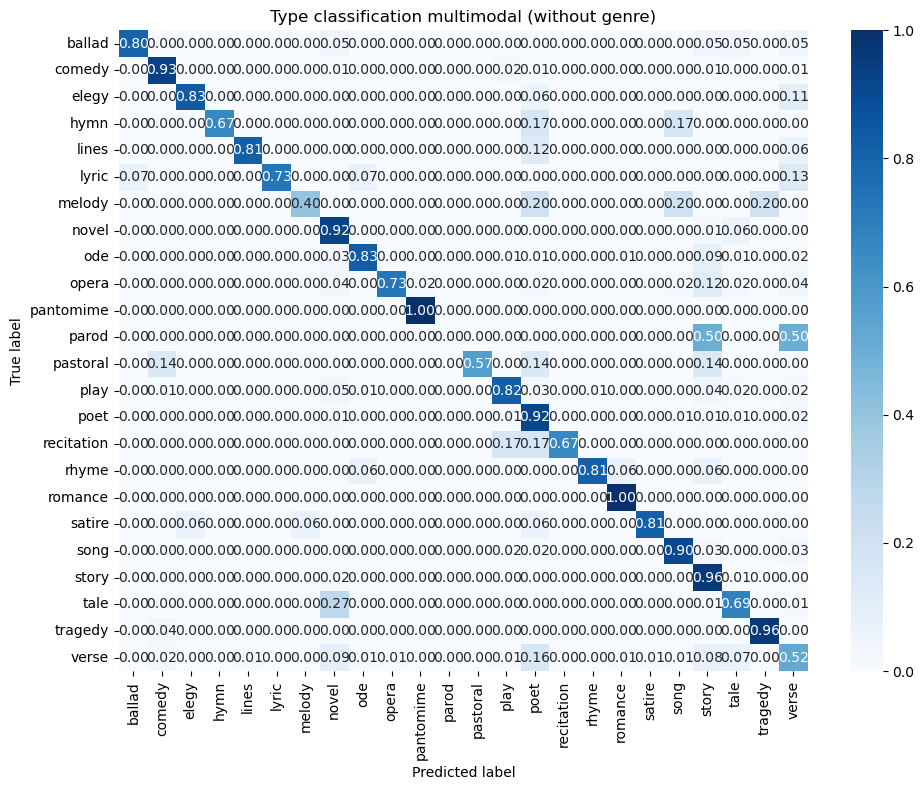

In [21]:
plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, fmt=".2f", cmap="Blues")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.title("Type classification multimodal (without genre)")
plt.tight_layout()
plt.show()

Uncertainty measures, based on SVM decisions margin

In [23]:
decision_scores = pipeline.decision_function(X_test) # gets decision score for each class
sorted_scores = np.sort(decision_scores, axis=1)
margins = sorted_scores[:, -1] - sorted_scores[:, -2] # margin uncertainty = difference between the highest and second highest score 
uncertainty_df = pd.DataFrame({
    "true_label": y_test.values,
    "predicted_label": y_pred,
    "margin": margins
}).sort_values("margin")
print("Most uncertain predictions (lowest margins):")
print(uncertainty_df.head(10))

Most uncertain predictions (lowest margins):
     true_label predicted_label    margin
2061       play            tale  0.000044
2011        ode            poet  0.000879
1134      verse            play  0.002075
656        play            play  0.002304
2840        ode           story  0.002728
2010      novel           novel  0.003189
2122        ode             ode  0.003376
207         ode           novel  0.003445
2423      verse            poet  0.003494
1717      verse           verse  0.004153


Plot the uncertainty measures

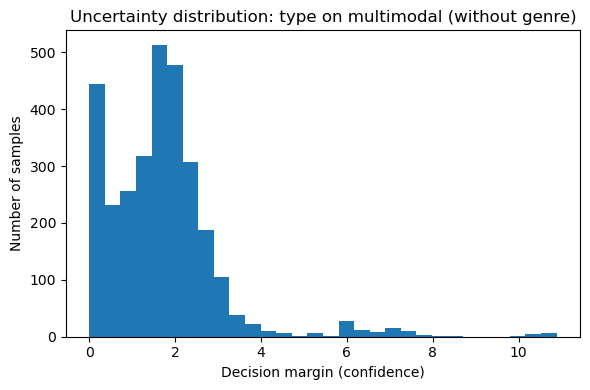

In [25]:
plt.figure(figsize=(6, 4))
plt.hist(margins, bins=30)
plt.xlabel("Decision margin (confidence)")
plt.ylabel("Number of samples")
plt.title("Uncertainty distribution: type on multimodal (without genre)")
plt.tight_layout()
plt.show()

Save the model

In [27]:
joblib.dump(pipeline, MODEL_FILENAME)
print(f"Model saved to: {MODEL_FILENAME}")

Model saved to: type_multimodal.pkl
